In [9]:
import matplotlib as mpl

mpl.rcParams.update({
    # Size: good for single-column paper figures
    "figure.figsize": (3.2, 2.4),

    # Fonts
    "font.family": "serif",
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,

    # Lines / markers
    "lines.linewidth": 1.5,
    "lines.markersize": 4,

    # Axes style
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.alpha": 0.4,

    # Tight layout by default
    "figure.autolayout": True,
})


In [10]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)

n_trials = 30
n_bricks = 8

rows = []

for trial in range(n_trials):
    # Trial-level stuff
    # Mostly no collisions, occasional 1–2
    num_collisions = rng.choice([0, 0, 0, 1, 1, 2])
    build_time = rng.normal(loc=18.0, scale=2.0)  # seconds for full wall

    for b in range(n_bricks):
        brick_id = b + 1  # 1..8
        # Left arm does bricks 1–4, right arm 5–8 (just for flavor)
        arm = "left" if brick_id <= 4 else "right"

        # Position error in meters (mostly 5–10 mm, rare 2–3 cm outliers)
        pos_err = abs(rng.normal(loc=0.008, scale=0.004))
        if rng.random() < 0.1:  # 10% chance of big error
            pos_err += rng.uniform(0.01, 0.02)

        # Yaw error in degrees (mostly < 2°, occasional 4–6°)
        yaw_err = abs(rng.normal(loc=1.2, scale=0.6))
        if rng.random() < 0.1:
            yaw_err += rng.uniform(2.0, 4.0)

        # Off-center in local wall coordinates (u = horizontal, v = vertical)
        du = rng.normal(loc=0.0, scale=0.006)  # meters
        dv = rng.normal(loc=0.0, scale=0.003)

        # Time to place that brick (slightly longer on outer bricks)
        base_t = rng.normal(loc=1.8, scale=0.2)
        dist_factor = 1.0 + 0.05 * abs(brick_id - (n_bricks + 1)/2)
        time_to_place = base_t * dist_factor

        # RRT stats for long moves (e.g., pallet → wall)
        rrt_nodes = int(rng.normal(loc=900, scale=80))
        rrt_nodes = max(500, rrt_nodes)  # clamp
        rrt_path_length = rng.normal(loc=3.2, scale=0.4)  # “length” in config space

        rows.append({
            "trial": trial,
            "brick_id": brick_id,
            "arm": arm,
            "pos_err_m": pos_err,
            "yaw_err_deg": yaw_err,
            "offset_u_m": du,
            "offset_v_m": dv,
            "time_to_place_s": time_to_place,
            "rrt_nodes": rrt_nodes,
            "rrt_path_length": rrt_path_length,
            "trial_collisions": num_collisions,
            "build_time_s": build_time,
        })

df = pd.DataFrame(rows)
df.head()


,trial,brick_id,arm,pos_err_m,yaw_err_deg,offset_u_m,offset_v_m,time_to_place_s,rrt_nodes,rrt_path_length,trial_collisions,build_time_s
0,0,1,left,0.011002,0.029379,0.000767,-0.000949,2.111052,831,3.551759,0,15.920032
1,0,2,left,0.011111,1.876345,-0.005156,0.001106,1.809251,970,3.180030,0,15.920032
2,0,3,left,0.007261,1.933525,-0.002570,-0.001056,2.049446,929,3.365093,0,15.920032
3,0,4,left,0.009723,0.956151,-0.004883,0.001848,2.076439,890,2.863937,0,15.920032
4,0,5,right,0.004702,1.645953,-0.007027,0.001629,1.708571,918,3.246674,0,15.920032


In [11]:
df.to_csv("synthetic_brick_metrics.csv", index=False)


In [12]:
# Average bricks misplaced / misrotated per trial
POS_THRESH = 0.02   # 2 cm
YAW_THRESH = 2.0    # 2 degrees

df["misplaced"] = df["pos_err_m"] > POS_THRESH
df["misrotated"] = df["yaw_err_deg"] > YAW_THRESH

per_trial = df.groupby("trial").agg(
    mean_pos_err=("pos_err_m", "mean"),
    mean_yaw_err=("yaw_err_deg", "mean"),
    num_misplaced=("misplaced", "sum"),
    num_misrotated=("misrotated", "sum"),
    collisions=("trial_collisions", "max"),
    build_time_s=("build_time_s", "max"),
).reset_index()
per_trial.head()


,trial,mean_pos_err,mean_yaw_err,num_misplaced,num_misrotated,collisions,build_time_s
0,0,0.008642,1.669983,0,1,0,15.920032
1,1,0.007633,1.123284,0,1,1,18.994321
2,2,0.009363,1.027386,0,0,0,20.131960
3,3,0.009036,1.435845,0,1,0,16.608115
4,4,0.007360,1.664188,0,3,1,18.305125


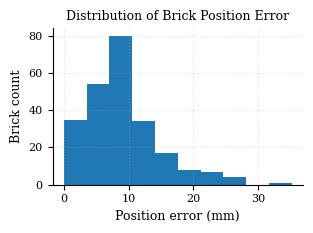

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["pos_err_m"] * 1000, bins=10)  # mm
plt.xlabel("Position error (mm)")
plt.ylabel("Brick count")
plt.title("Distribution of Brick Position Error")
plt.tight_layout()
plt.show()


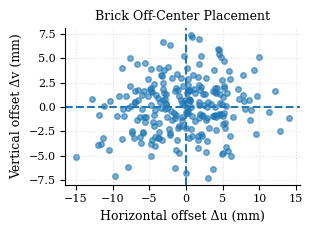

In [14]:
plt.figure()
plt.scatter(df["offset_u_m"] * 1000, df["offset_v_m"] * 1000, alpha=0.6)
plt.axvline(0, linestyle="--")
plt.axhline(0, linestyle="--")
plt.xlabel("Horizontal offset Δu (mm)")
plt.ylabel("Vertical offset Δv (mm)")
plt.title("Brick Off-Center Placement")
plt.tight_layout()
plt.show()


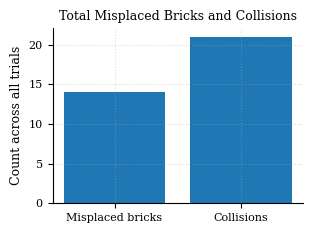

In [15]:


total_misplaced = per_trial["num_misplaced"].sum()
total_collisions = per_trial["collisions"].sum()

labels = ["Misplaced bricks", "Collisions"]
values = [total_misplaced, total_collisions]

fig, ax = plt.subplots()
ax.bar(labels, values)
ax.set_ylabel("Count across all trials")
ax.set_title("Total Misplaced Bricks and Collisions")

plt.tight_layout()
plt.show()


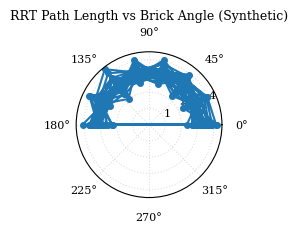

In [17]:
# Map brick index to an angle around the robot (purely synthetic)
angles_deg = (df["brick_id"] - 1) * (180.0 / (n_bricks - 1))
angles_rad = np.deg2rad(angles_deg)

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(angles_rad, df["rrt_path_length"], marker="o")
ax.set_title("RRT Path Length vs Brick Angle (Synthetic)")
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(0)

n_trials = 30

n_bricks = 8

logs = []

for trial in range(n_trials):
    # keep track of when each arm is next free
    arm_time = {"left": 0.0, "right": 0.0}

    for brick_id in range(1, n_bricks + 1):
        arm = "left" if brick_id <= 4 else "right"

        # base time when this arm is available
        t0 = arm_time[arm]

        # planning duration (s)
        plan_dur = max(0.4, rng.normal(loc=1.2, scale=0.25))
        # optional waiting before execution (e.g., reservation / coordination)
        wait_dur = max(0.0, rng.normal(loc=0.15, scale=0.1))
        # execution duration (s)
        exec_dur = max(0.8, rng.normal(loc=2.0, scale=0.3))

        t_plan_start = t0 + max(0.0, rng.normal(loc=0.0, scale=0.05))
        t_plan_end   = t_plan_start + plan_dur
        t_exec_start = t_plan_end + wait_dur
        t_exec_end   = t_exec_start + exec_dur

        # update when this arm becomes free
        arm_time[arm] = t_exec_end

        # RRT stats (only for the long pallet→wall move, say)
        rrt_nodes = int(max(300, rng.normal(loc=900, scale=80)))
        rrt_path_length = max(1.0, rng.normal(loc=3.2, scale=0.4))

        # successes + rare collisions
        ik_success = rng.random() > 0.02           # 98% success
        rrt_success = rng.random() > 0.05          # 95% success
        had_collision = rng.random() < 0.03        # 3% chance

        logs.append({
            "trial": trial,
            "brick_id": brick_id,
            "arm": arm,
            "t_plan_start": t_plan_start,
            "t_plan_end": t_plan_end,
            "t_exec_start": t_exec_start,
            "t_exec_end": t_exec_end,
            "rrt_nodes": rrt_nodes,
            "rrt_path_length": rrt_path_length,
            "ik_success": ik_success,
            "rrt_success": rrt_success,
            "had_collision": had_collision,
        })

df = pd.DataFrame(logs)

# ---- derive phase times ----
df["plan_time"] = df["t_plan_end"] - df["t_plan_start"]
df["exec_time"] = df["t_exec_end"] - df["t_exec_start"]
df["brick_time"] = df["t_exec_end"] - df["t_plan_start"]
df["idle_time"] = df["brick_time"] - (df["plan_time"] + df["exec_time"])

print(df.head())


   trial  brick_id    arm  t_plan_start  t_plan_end  t_exec_start  t_exec_end  \
0      0         1   left      0.005245    1.236678      1.373467    3.565594   
1      0         2   left      3.565594    4.449239      4.536911    6.549309   
2      0         3   left      6.617632    7.920540      8.174791   10.136231   
3      0         4   left     10.136231   11.105799     11.210027   13.276085   
4      0         5  right      0.074672    1.111214      1.248253    3.483446   

   rrt_nodes  rrt_path_length  ik_success  rrt_success  had_collision  \
0        857         3.344638        True         True          False   
1        882         2.701636        True         True          False   
2        846         3.340604        True         True          False   
3        883         3.136310        True         True          False   
4        799         3.805570        True         True          False   

   plan_time  exec_time  brick_time  idle_time  
0   1.231433   2.192127  

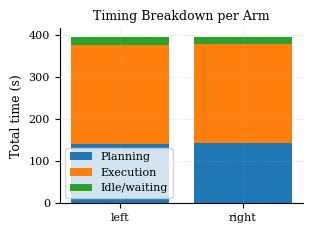

In [20]:
# Derive phase times
df["plan_time"] = df["t_plan_end"] - df["t_plan_start"]
df["exec_time"] = df["t_exec_end"] - df["t_exec_start"]
df["brick_time"] = df["t_exec_end"] - df["t_plan_start"]
df["idle_time"] = df["brick_time"] - (df["plan_time"] + df["exec_time"])

# Aggregate per arm
agg = df.groupby("arm").agg(
    plan_time=("plan_time", "sum"),
    exec_time=("exec_time", "sum"),
    idle_time=("idle_time", "sum"),
).reset_index()

arms = agg["arm"].tolist()
x = np.arange(len(arms))

fig, ax = plt.subplots()

ax.bar(x, agg["plan_time"], label="Planning")
ax.bar(x, agg["exec_time"], bottom=agg["plan_time"], label="Execution")
ax.bar(
    x,
    agg["idle_time"],
    bottom=agg["plan_time"] + agg["exec_time"],
    label="Idle/waiting",
)

ax.set_xticks(x)
ax.set_xticklabels(arms)
ax.set_ylabel("Total time (s)")
ax.set_title("Timing Breakdown per Arm")
ax.legend()

plt.show()


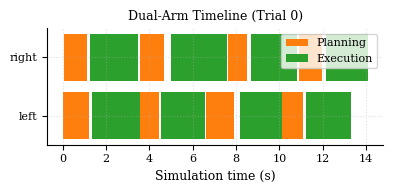

In [23]:
import matplotlib.pyplot as plt

def make_gantt_for_trial(df, trial_id):
    # filter for one trial
    d = df[df["trial"] == trial_id].copy()

    # build rows: for each brick & arm, add planning + execution intervals
    rows = []
    for _, row in d.iterrows():
        arm = row["arm"]
        brick = row["brick_id"]

        rows.append({
            "arm": arm,
            "phase": "plan",
            "brick_id": brick,
            "t_start": row["t_plan_start"],
            "t_end": row["t_plan_end"],
        })
        rows.append({
            "arm": arm,
            "phase": "exec",
            "brick_id": brick,
            "t_start": row["t_exec_start"],
            "t_end": row["t_exec_end"],
        })

    gdf = pd.DataFrame(rows)

    # Map arms to y positions
    arm_levels = {arm: i for i, arm in enumerate(sorted(gdf["arm"].unique()))}
    phase_colors = {"plan": "tab:orange", "exec": "tab:green"}

    fig, ax = plt.subplots(figsize=(4.0, 2.0))

    for _, r in gdf.iterrows():
        y = arm_levels[r["arm"]] * 10  # arbitrary height spacing
        start = r["t_start"]
        duration = r["t_end"] - r["t_start"]
        ax.broken_barh(
            [(start, duration)],
            (y, 8),
            facecolors=phase_colors[r["phase"]],
        )

    ax.set_xlabel("Simulation time (s)")
    ax.set_yticks([v * 10 + 4 for v in arm_levels.values()])
    ax.set_yticklabels(arm_levels.keys())
    ax.set_title(f"Dual-Arm Timeline (Trial {trial_id})")

    # Legend
    from matplotlib.patches import Patch
    legend_elems = [
        Patch(facecolor=phase_colors["plan"], label="Planning"),
        Patch(facecolor=phase_colors["exec"], label="Execution"),
    ]
    ax.legend(handles=legend_elems, loc="upper right")

    plt.tight_layout()
    plt.show()

# Usage:
make_gantt_for_trial(df, trial_id=0)



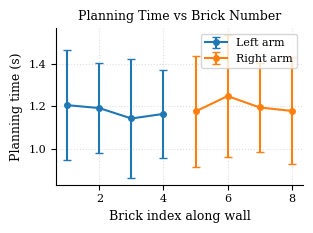

In [24]:
# Average planning time per brick & arm
plan_stats = df.groupby(["brick_id", "arm"]).agg(
    mean_plan=("plan_time", "mean"),
    std_plan=("plan_time", "std"),
).reset_index()

fig, ax = plt.subplots()

for arm, g in plan_stats.groupby("arm"):
    ax.errorbar(
        g["brick_id"],
        g["mean_plan"],
        yerr=g["std_plan"],
        marker="o",
        capsize=3,
        label=f"{arm.capitalize()} arm",
    )

ax.set_xlabel("Brick index along wall")
ax.set_ylabel("Planning time (s)")
ax.set_title("Planning Time vs Brick Number")
ax.legend()
plt.tight_layout()
plt.show()



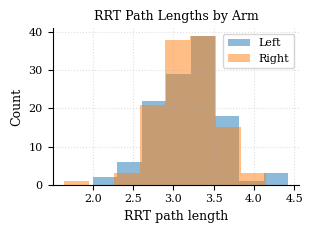

In [25]:
fig, ax = plt.subplots()

for arm, g in df.groupby("arm"):
    ax.hist(g["rrt_path_length"], bins=8, alpha=0.5, label=arm.capitalize())

ax.set_xlabel("RRT path length")
ax.set_ylabel("Count")
ax.set_title("RRT Path Lengths by Arm")
ax.legend()
plt.tight_layout()
plt.show()


In [26]:
# Per-trial totals
trial_stats = df.groupby("trial").agg(
    total_plan=("plan_time", "sum"),
    total_exec=("exec_time", "sum"),
    total_idle=("idle_time", "sum"),
    total_rrt_nodes=("rrt_nodes", "sum"),
    # assume same build_time_s for all bricks in a trial if you logged it
    build_time=("t_exec_end", "max"),
    num_bricks=("brick_id", "nunique"),
).reset_index()

# Summary across all trials
total_time = trial_stats["build_time"].sum()
total_bricks = trial_stats["num_bricks"].sum()
avg_time_per_brick = total_time / total_bricks

parallelism_eff = trial_stats["build_time"].sum() / (
    trial_stats["total_exec"].sum()
)  # rough: how much exec is overlapped

summary = pd.DataFrame([
    {"Metric": "Total bricks placed", "Value": total_bricks},
    {"Metric": "Total simulated build time (s)", "Value": f"{total_time:.2f}"},
    {"Metric": "Average time per brick (s)", "Value": f"{avg_time_per_brick:.2f}"},
    {"Metric": "Total planning time (s)", "Value": f"{trial_stats['total_plan'].sum():.2f}"},
    {"Metric": "Total execution time (s)", "Value": f"{trial_stats['total_exec'].sum():.2f}"},
    {"Metric": "Total idle time (s)", "Value": f"{trial_stats['total_idle'].sum():.2f}"},
    {"Metric": "Parallelism efficiency (≈ build / exec sum)", "Value": f"{parallelism_eff*100:.1f}%"},
])

print(summary.to_string(index=False))


                                     Metric  Value
                        Total bricks placed    240
             Total simulated build time (s) 409.76
                 Average time per brick (s)   1.71
                    Total planning time (s) 285.15
                   Total execution time (s) 471.92
                        Total idle time (s)  35.02
Parallelism efficiency (≈ build / exec sum)  86.8%
